# Convince customer not to churn
Or: how to prevent the customer to leave the company. This can be a company providing subscription-based services or public utilities the customer pays for on a regular basis. This notebook takes a fictitious cable operator that struggles with customers wanting to leave the company. Partly based on [Harvard CS109-2015 Lab6](https://github.com/cs109/2015lab6).

Customer churn, also known as customer attrition, is the loss of clients or customers.

#### Necessary libraries

In [1]:
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

## Business case
Will the customer leave the company? What costs needed to convince customer to stay?

The goal is to reduce customer churn by identifying potential churn candidates beforehand, and take proactive actions to make them stay: consider an incentive for the customer to stay with the cable company. From a business perspective the costs to stay should be as low as possible. Some models will be compared to find the best (= lowest costs) classifier.

## Data preprocessing
This encompasses the design and creation of the datafile, the loading of this file into a dataset and some cleaning.

### Datafile
The cable operator company data comes in a CSV file. This datafile is not based on any other existing example from Harvard CS109 or elsewhere. It is created mainly in the VI editor and (just for the TotalCharges calculation) in Excel. The dataset has the following variables:
* *CustomerID*: Customer ID
* *Province*: Dutch province abbreviation
* *Area*: geographical indication
* *Phone*: telephone-number
* *Multiple Lines*: whether customer has multiple lines or not (yes, no)
* *Combi Contract*: whether customer has combined subscription for telephone, TV and internet (yes, no)
* *Internet Speed*: download speed in mbits/s (50, 250, 500, 1000)
* *TV Subscription*: type of TV subscription (Basic, Extra, Super)
* *Tenure*: number of months the customer has stayed with the company
* *Monthly Charges*: the amount (€) charged to the customer monthly
* *Total Charges*: the total amount (€) charged to the customer (cumulative)
* *Payment Method*: customer’s payment method (Manual Transfer, iDeal, Direct Debit)
* *Extended Security*: whether the customer has online security or not above default of 1 asset (yes, no) 
* *CustServ Calls*: number of registered tech support calls
* *Churn*: wether the customer churned or not (True., False.)



### Dataset
Load file into a Pandas dataset and evaluate the datastructure.

In [2]:
df=pd.read_csv("data/custChurn.csv")

In [3]:
df.head()

,CustomerID,Province,Area,Phone,Multiple Lines,Combi Contract,Internet Speed,TV Subscription,Tenure,Monthly Charges,Total Charges,Payment Method,Extended Security,CustServ Calls,Churn
0,1512,LB,South,045-4039199,no,yes,250,Basic,8,53.5,428.0,Direct Debit,no,2.0,False.
1,0903,GD,Center,030-4034200,no,no,250,Basic,14,53.5,749.0,Direct Debit,no,2.0,False.
2,0928,GD,Center,030-4107789,no,no,250,Basic,9,53.5,481.5,Direct Debit,no,1.0,False.
3,2513,UT,Center,030-3606416,no,no,250,Basic,31,53.5,1658.5,Direct Debit,no,0.0,False.
4,0146,DR,North,050-3965790,no,yes,250,Basic,37,53.5,1979.5,Direct Debit,no,1.0,False.


In [4]:
df.shape

(3334, 15)

The dataset has 3334 rows each with 15 attributes. A `Churn` value `True.` indicates the customer leaves the company.

In [5]:
df.columns

Index(['CustomerID', 'Province', 'Area', 'Phone', 'Multiple Lines', 'Combi Contract', 'Internet Speed', 'TV Subscription', 'Tenure', 'Monthly Charges', 'Total Charges', 'Payment Method', 'Extended Security', 'CustServ Calls', 'Churn'], dtype='object')

In [6]:
df.describe()

,Internet Speed,Tenure,Monthly Charges,Total Charges,CustServ Calls
count,3334.000000,3334.000000,3334.000000,3334.000000,3333.000000
mean,353.629274,21.017097,59.812687,1257.735753,2.960396
std,245.997718,16.967575,11.030082,1057.428725,3.956348
min,50.000000,1.000000,53.500000,53.500000,0.000000
25%,250.000000,8.000000,53.500000,442.500000,1.000000
50%,250.000000,18.000000,53.500000,1016.500000,2.000000
75%,500.000000,31.000000,68.000000,1872.500000,3.000000
max,1000.000000,90.000000,88.500000,6106.500000,50.000000


Check for missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3334 entries, 0 to 3333
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         3334 non-null   object 
 1   Province           3334 non-null   object 
 2   Area               3334 non-null   object 
 3   Phone              3334 non-null   object 
 4   Multiple Lines     3334 non-null   object 
 5   Combi Contract     3334 non-null   object 
 6   Internet Speed     3334 non-null   int64  
 7   TV Subscription    3334 non-null   object 
 8   Tenure             3334 non-null   int64  
 9   Monthly Charges    3334 non-null   float64
 10  Total Charges      3334 non-null   float64
 11  Payment Method     3334 non-null   object 
 12  Extended Security  3334 non-null   object 
 13  CustServ Calls     3333 non-null   float64
 14  Churn              3334 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 390.8+ KB


**Three observations** from the above info:
* `Multiple Lines`, `Combi Contract` and `Extended Security` are expected to be booleans. 
* Attribute `CustServ Calls` is expected to be an integer value. Let's find out what is wrong here.
* `Payment Method` is likely to be a categorical value. Current values (iDeal, Direct Debit and Manual Transfer) are expected to give problems as machine learning algorithms operate on numericals only. 

In [8]:
# Assign boolean values
df['Multiple Lines'] = df['Multiple Lines']=='yes'
print('Type Multiple Lines: ', df.dtypes['Multiple Lines'])
df['Combi Contract'] = df['Combi Contract']=='yes'
print('Type Combi Contract: ', df.dtypes['Combi Contract'])
df['Extended Security'] = df['Extended Security']=='yes'
print('Type Extended Security: ', df.dtypes['Extended Security'])
# Check why CustServ Calls is typed as float64
df[df['CustServ Calls'].isnull()]

# we deal with Payment Method later on

Type Multiple Lines:  bool
Type Combi Contract:  bool
Type Extended Security:  bool


,CustomerID,Province,Area,Phone,Multiple Lines,Combi Contract,Internet Speed,TV Subscription,Tenure,Monthly Charges,Total Charges,Payment Method,Extended Security,CustServ Calls,Churn
3333,3335,GR,North,050-3303429,False,False,50,Basic,31,53.5,1658.5,Direct Debit,False,NaN,False.


So, just one row has incomplete data (NaN). It will be removed:

In [9]:
df = df[df['CustServ Calls'].notnull()]
df.shape

(3333, 15)

### Data cleaning
The CustomerID variable is not needed for graphs or modeling, so it can be removed.

In [10]:
df.drop(['CustomerID'], axis=1, inplace=True)

* Continuous variables: Tenure, CustServ Calls, Monthly Charges
* Categorical variables: Multiple Lines, Combi Contract, Extended Security, Payment Method

## Exploratory Data Analysis
The distribution of the target value `Churn` shows an imbalance with a hight proportion of loyal customers. This is visible in the 3 cells below.

In [11]:
df['Churn'].value_counts()

False.    2847
True.      486
Name: Churn, dtype: int64

In [12]:
# Sample percentage of people who churned
dfyes=df[df['Churn']=='True.']
print(100*(len(dfyes)/len(df)), '%')

14.581458145814583 %


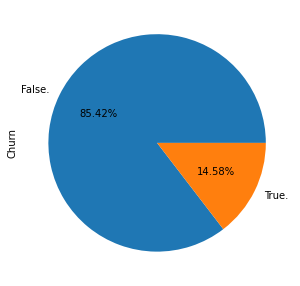

In [13]:
plot = df.Churn.value_counts().plot.pie(y='Churn', figsize=(5, 5), autopct='%1.2f%%')

### Continuous variables
These are variables that would (literally) take forever to count. In `df` dataset: Tenure, CustServ Calls, Monthly Charges, Total Charges. To examine we use Seaborn's pairplot:

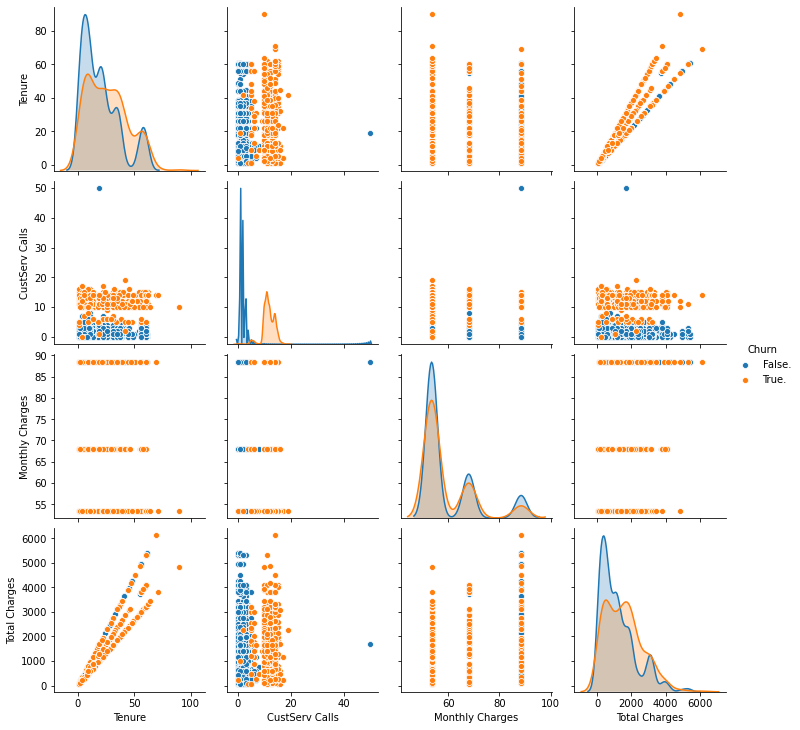

In [14]:
sns.pairplot(df[['Churn', 'Tenure','CustServ Calls', 'Monthly Charges', 'Total Charges']], hue='Churn')

From the above pairplot one might conclude:
* the more customer service calls, the more churners. 
* the number of churners seems independent from the Monthly Charges
* more churners than staying customers roughly between 1900 and 3000 Total Charges

So, the cable company's Customer Service department apparently doesn't handle questions and complaints well.

In [15]:
#cols_continuous=['Tenure','CustServ Calls', 'Monthly Charges', 'Total Charges']
cols_continuous=['Tenure','CustServ Calls', 'Monthly Charges']
df[cols_continuous].shape[0]

3333

In [ ]:
df[cols_continuous].iloc[:, 0]

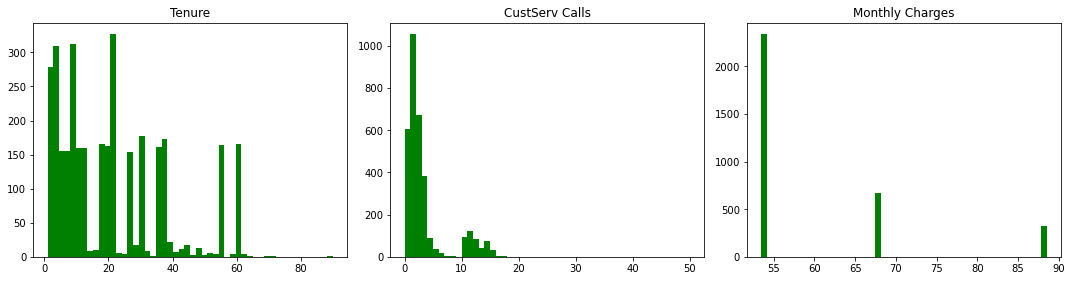

In [16]:
fig = plt.figure(figsize=(15, 12))
for i in range(df[cols_continuous].shape[1]):
    plt.subplot(3, 3, i + 1)
    f = plt.gca()
    f.set_title(df[cols_continuous].columns.values[i])
    plt.hist(df[cols_continuous].iloc[:, i], bins=50, color = 'green')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Categorical variables
Or distinct variables.

In [17]:
#cols_categorical=['Payment Method', 'Multiple Lines', 'Combi Contract', 'Extended Security']
cols_categorical=['Payment Method', 'Multiple Lines', 'Combi Contract']
df[cols_categorical].shape[0]

3333

In [18]:
print(df['Payment Method'].nunique(), ' payment methods')
print('They are:', df['Payment Method'].unique())

3  payment methods
They are: ['Direct Debit' 'Manual Transfer' 'iDeal']


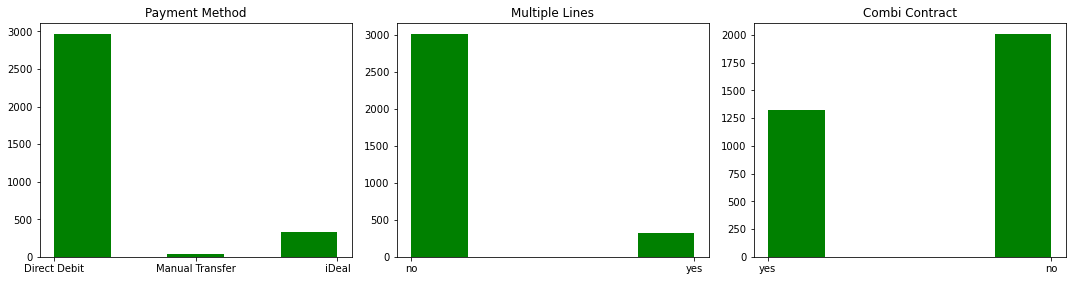

In [19]:
fig = plt.figure(figsize=(15, 12))
for i in range(df[cols_categorical].shape[1]):
    plt.subplot(3, 3, i + 1)
    f = plt.gca()
    f.set_title(df[cols_categorical].columns.values[i])
    if df[cols_categorical].iloc[:, i].dtype == bool: #convert True to yes, False to no.
        c=['yes' if i else 'no' for i in df[cols_categorical].iloc[:, i]]
        plt.hist(c, bins=5, color = 'green')
    else:
        plt.hist(df[cols_categorical].iloc[:, i], bins=5, color = 'green')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Modeling
It was found that the positives, or the people who churned, only make up 14-15% of the samples. This means that a classifier which predicts that EVERY customer is a negative (does not churn) has an accuracy rate of 85-86%. But as we have seen, on such asymmetric data sets, accuracy is just not a good metric. <br>
We will begin with the confustion matrix, which is a useful display of classification accuracy. It displays the following information:

    true positives (TP): These are cases in which we predicted yes (they churned), and they did churn.
    true negatives (TN): We predicted no, and they didn’t churn.
    false positives (FP): We predicted yes, but they didn’t actually churn. (Also known as a “Type I error.”)
    false negatives (FN): We predicted no, but they actually churned. (Also known as a “Type II error.”)
<br>
Suppose two classifiers A and B, as depicted below, were trained on a balanced training set (Balanced Population). Classifier A makes mistakes on the FP's: non-churners(n) predicted to churn(Y) while classifier B makes mistakes on the FN's: churners(p) predicted not to churn(N). <br>In The True Population below resembles our dataset with about 15% positives, the churners (p). Classifier B seems to make less mistakes than A: they were predicted not to churn, but do. These FN's are very costly. One might consider classifier A having FP's although less accurate.

![m:abmodeldiag](data/abmodeldiag.png)
Source: Fawcett and Provost, 1997

### Business - keep costs low
To find the lowest costs, classifiers must be compared. Two obvious baselines are:
* all customers stay (don't churn). The accuracy on the dataset is around 85%.
* all customers leave (all churn). The accuracy on the dataset is around 15%.

In this imbalanced situation the accuracy is not a good metric. To minimize the cost/maximize the profit for the cable operator we need to understand the business situation. To do this, we write a **utility**, or, equivalently, **cost** matrix associated with the 4 scenarios that the confusion matrix talks about. 

![cost matrix](data/costmatrix.png)
0's are customers who stay, 1's are churning customers.

The company makes the customer a one-time offer. They receive an incentive of €100 to stay. A churning customer means loss of profit which can be roughly estimated as the average number of months the customer is with the company times the net monthly revenue. 

Let's assume we make an offer with an administrative cost of €3 and an offer cost of €100, an incentive for the customer to stay with us. If a customer leaves us, we lose the customer lifetime value, which is some kind of measure of the lost profit from that customer. Lets assume this is the average number of months a customer stays with the telecom times the net revenue from the customer per month. We'll assume 3 years and €30/month margin per user lost, for roughly a €1200 loss.

* true positives (TPC): These are cases in which we predicted yes (they churned), and they did churn. The company tries to convince these people to stay. **Costs:** `f * offer + (1-f) * (admin + customer lifetime value)]`. `f` is the fraction of people that stay with us. So `1 - f` is the fraction of people who would leave. 
* true negatives (TNC): We predicted no, and they didn’t churn. No costs as they remain customers. **Costs:** `0`
* false positives (FPC): We predicted yes, but they didn’t actually churn. Costs made by company: **Costs:** `admin + offer`. This money is lost.
* false negatives (FNC): We predicted no, but they actually churned. This is company's big loss. **Costs:** `customer lifetime value`.

In [20]:
admin_cost = 5
offer_cost = 100
clv = 1200 #customer lifetime value

In [21]:
f = 0.5
tpc = f * offer_cost + (1. - f) * (admin_cost + clv)
tnc = 0.
fpc = admin_cost + offer_cost
fnc = clv
cost_matrix = np.array([[tnc, fpc], [fnc, tpc]])
print(cost_matrix)

[[   0.   105. ]
 [1200.   652.5]]


The average cost/profit per person can be calculated using this formula (taken from Harvard CS109-2015 Lab6):

\begin{eqnarray}
Cost &=& c(1P,1A) \times p(1P,1A) + c(1P,0A) \times p(1P,0A) + c(0P,1A) \times p(0P,1A) + c(0P,0A) \times p(0P,0A) \\
&=& \frac{TP \times c(1P,1A) + FP \times c(1P,0A) + FN \times c(0P,1A) + TN \times c(0P,0A)}{N}
\end{eqnarray}

where:
* 1P is **predictions** for class 1, the positives or churning customers
* 0A is **actual** values of the negative class 0, or staying customers
* N is total size of the test set

Explained in Lab6.

We implement this process of finding the average cost per person in the average_cost function below:

In [22]:
def average_cost(y, yPred, cost):
    c = confusion_matrix(y, yPred)
    score = np.sum(c * cost) / np.sum(c)
    return score

### Preliminary calculations
Let's look at two extremes: 
1. all customers stay and the company sends nothing
2. all customers leave and the company sends to everyone

But first create a training and a test set.

In [ ]:
# INTERMEZZO
# Understanding the mask
testMask = np.array([True, True, False, True, True, True, False, False, True, False])
# make some test dataframe 
data = {'Churn':['True.', 'False.', 'False.', 'False.', 'True.', 'False.', 'False.', 'False.', 'True.', 'True.']} 
dfTest = pd.DataFrame(data)
print(dfTest['Churn'][testMask])
# tilde operator (~) flips boolean value in np arrays. Prints the values from dfTest where testMask value = False.
print(dfTest['Churn'][~testMask])

In [23]:
# split on just X 
X_train, X_test = train_test_split(range(df.shape[0]), train_size=0.6)
churnmask = np.ones(df.shape[0], dtype='int') # returns array with 1's
churnmask[X_train] = 1 # value 1 assigned to X_train (60% of df) => 1 = churning
churnmask[X_test] = 0 # value 0 assigned to X_test (40% of df) => 0 => staying
churnmask = (churnmask == 1) # convert to True (X_train) and False (X_test)
churnmask

array([ True,  True,  True, ...,  True,  True, False])

In [24]:
# Testchurner: value from df['Churn'] where churnMask value = False. Converted to boolean (.values=='True.')
testchurners=df['Churn'][~churnmask].values=='True.'

In [25]:
# Testsize of these testchurners
testsize = df[~churnmask].shape[0]

#### No customer churns, company sends nothing 

In [26]:
yPred_dste = np.zeros(testsize, dtype="int") # All customers stay
print (confusion_matrix(testchurners, yPred_dste))

[[1159    0]
 [ 175    0]]


In [27]:
dsteval = average_cost(testchurners, yPred_dste, cost_matrix)
dsteval

157.42128935532233

#### All churning customers, company sends to everyone

In [28]:
yPred_ste = np.ones(testsize, dtype="int") # All customers churn
print (confusion_matrix(testchurners, yPred_ste))

[[   0 1159]
 [   0  175]]


In [30]:
steval = average_cost(testchurners, yPred_ste, cost_matrix)
steval

187.0839580209895

### Classifiers to test 
From the above: sending offers to everyone is more expensive than doing nothing. So the focus is on sending nothing; the challenge is to find a classifier giving the lowest costs. 
#### Functions for all classifiers to be tested
The below functions `do_classify(), cv-optimize(), points_plot()` and `points_plot_prob()` are literally taken from Harvard CS109-2015 Lab6. At this point we also need to convert the categorical value `Payment Method`:

In [29]:
df['Payment Method'] = df['Payment Method'].astype('category').cat.codes
df['Payment Method'].unique()

array([0, 1, 2], dtype=int8)

In [30]:
# Our work horse doing the classification.
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask is not None:
        print ("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print ("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print ("############# based on standard predict ################")
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    print (confusion_matrix(ytest, clf.predict(Xtest)))
    print ("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [31]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print ("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best

In [32]:
def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [33]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
#    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return ax

In [34]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    plt.figure(figsize=(16,10))
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

#### Gaussian Naive Bayes
The first classifier to try is Gaussian Naive Bayes, abbreviated `gnb`. We'll just use the default parameters, since the actual details are not of importance to us.

In [35]:
clf_gnb = GaussianNB()
clf_gnb, Xtrain, ytrain, Xtest, ytest = do_classify(clf_gnb, None, df, cols_continuous+cols_categorical, 'Churn', "True.", mask=churnmask)

using mask
############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.98
[[1136   23]
 [   1  174]]
########################################################


In [36]:
average_cost(ytest, clf_gnb.predict(Xtest), cost_matrix)

87.81859070464768

OK, a giant drop in costs per customer. Can this be trusted? In sklearn, clf.predict(test_data) makes predictions on the assumption that a 0.5 probability threshold is the appropriate thing to do.
##### Repredict
Do you really want to be setting a threshold of 0.5 probability to predict if a customer churns or not? The false negative problem: ie the chance you predict the customer doesn't churn while he churns is much higher for such a threshold. This is the big loss for the company. In our case of such asymmetric costs, the sklearn API function predict is useless. False negatives FN are far more expensive than false positives FP; a prediction with a lower threshold might be more realistic.


In [37]:
def repredict(estimator, threshold, xtest):
    probs=estimator.predict_proba(xtest)
    p0 = probs[:,0] #probablility for 0 
    p1 = probs[:,1] #probablility for 1
    ypred = (p1 >= threshold)*1
    return ypred

In [38]:
average_cost(ytest, repredict(clf_gnb, 0.3, Xtest), cost_matrix)

88.44827586206897

**This is odd**. Average cost at 0.3 threshold almost identical to the average using `predict()`. Looking at the threshold histogram below, it was expected to be lower than the costs at threshold 0.5. <br>It might be due to incoherent data in the dataset. 

(array([1.096e+03, 3.200e+01, 1.000e+00, 4.000e+00, 4.000e+00, 7.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 1.830e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

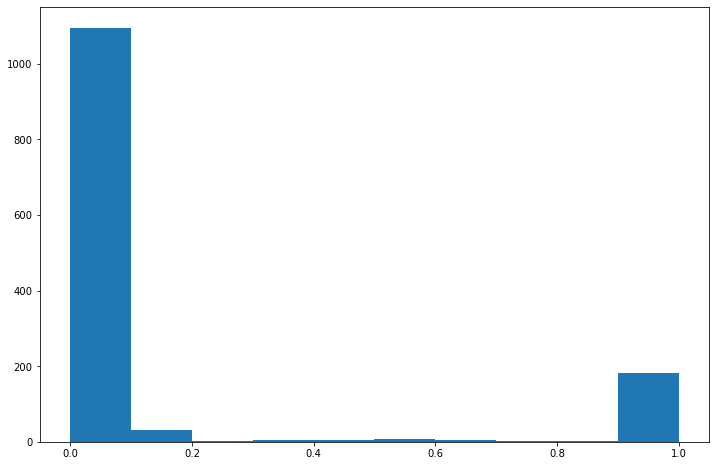

In [39]:
plt.figure(figsize=(12,8))
plt.hist(clf_gnb.predict_proba(Xtest)[:,1])

ROC curves are actually a set of classifiers, in which we move the threshold for classifying a sample as positive from 0 to 1. (In the standard scenario, where we use classifier accuracy, this threshold is implicitly set at 0.5).

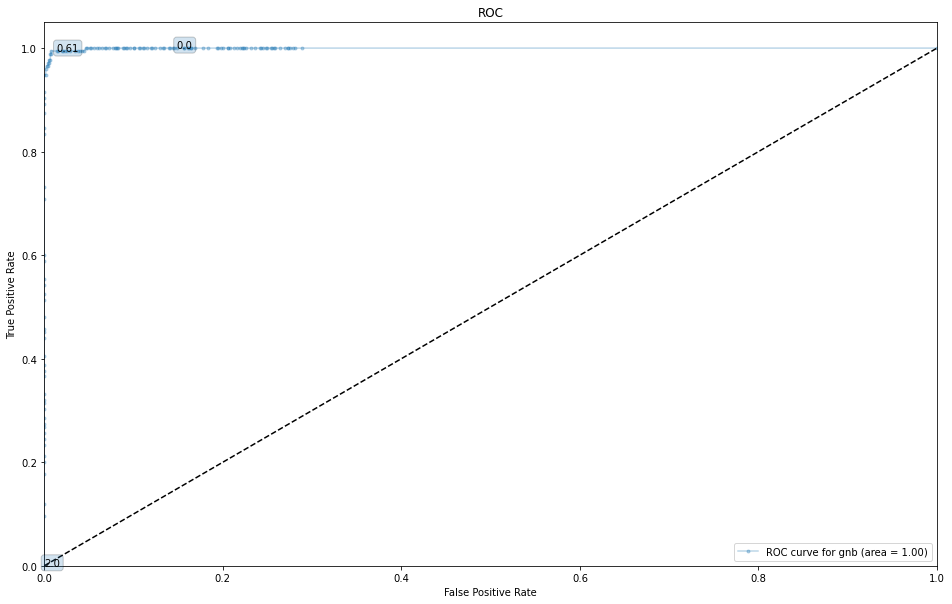

In [40]:
#gnb = Gaussian Naive Bayes classifier
make_roc("gnb",clf_gnb, ytest, Xtest, None, labe=50)

#### Decision trees 

In [41]:
# make dictionary using built-in dict()
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [42]:
clf_dt=DecisionTreeClassifier()
clf_dt, Xtrain, ytrain, Xtest, ytest  = do_classify(clf_dt, {"max_depth": range(1,10,1)}, df, cols_continuous+cols_categorical, 'Churn', "True.", reuse_split=reuse_split)

using reuse split
BEST {'max_depth': 6} 0.9939974937343358 {'mean_fit_time': array([0.00312424, 0.00312414, 0.00130167, 0.        , 0.        ,
       0.00311909, 0.        , 0.00312352, 0.        ]), 'std_fit_time': array([0.00624847, 0.00624828, 0.00260334, 0.        , 0.        ,
       0.00623817, 0.        , 0.00624704, 0.        ]), 'mean_score_time': array([0.        , 0.        , 0.00312505, 0.        , 0.00312414,
       0.        , 0.00313039, 0.        , 0.        ]), 'std_score_time': array([0.        , 0.        , 0.0062501 , 0.        , 0.00624828,
       0.        , 0.00626078, 0.        , 0.        ]), 'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 1}, {'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}, {'max_depth': 8}, {

#### Compare
Compare Gaussian Naive Bayes and Decision Tree by plotting ROC curves.

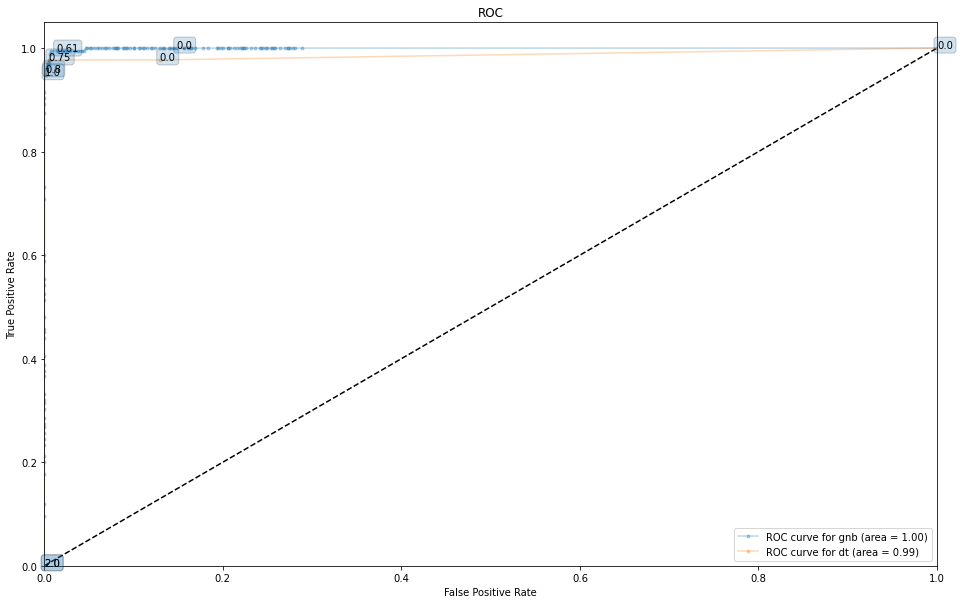

<Figure size 1152x720 with 0 Axes>

In [43]:
ax=make_roc("gnb",clf_gnb, ytest, Xtest, None, labe=50)
make_roc("dt",clf_dt, ytest, Xtest, ax, labe=1)

The AUC (area under curve) for both is almost 1. Probably datafile resuls in this plot. 

##### Repredict on costs
The key idea is that we want to minimize cost on our test set, so for each sample, simply pick the class which does that. The theory behind loss through picking a class and decision loss is i.m.o. complex and amongst others described in CS109 Lab6.

In [44]:
cost_matrix

array([[   0. ,  105. ],
       [1200. ,  652.5]])

In [45]:
# cost ratio's
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [46]:
# cost repredict
def cost_repredict(estimator, cost, xtest):
    r = rat(cost)
    print (r)
    t=r/(1.+r)
    print ("threshold=", t)
    probs=estimator.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [47]:
average_cost(ytest, cost_repredict(clf_dt, cost_matrix, Xtest), cost_matrix)

0.1917808219178082
threshold= 0.16091954022988506


87.71176911544228

Now plot the cost curve for both classifiers to find the minimum cost. X-axis the threshold (only dependent on costs; independent of classifier). Y-axix the costs.

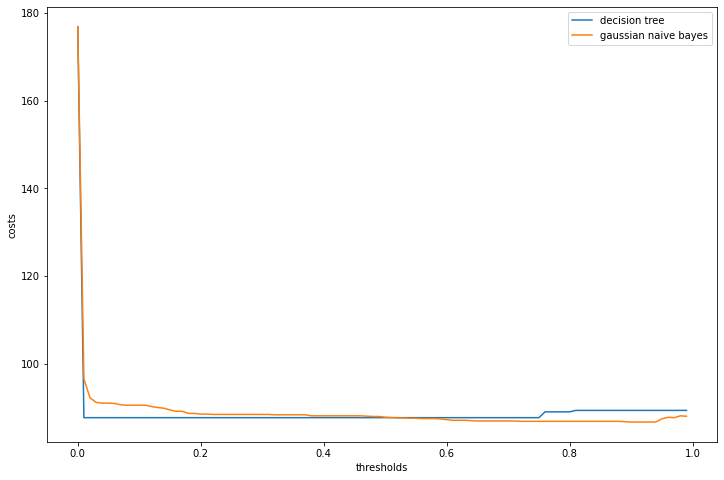

In [48]:
ts=np.arange(0.0, 1.0, 0.01)
plt.figure(figsize=(12,8))
plt.plot(ts, [average_cost(ytest, repredict(clf_dt, t, Xtest), cost_matrix) for t in ts], label='decision tree' )
plt.plot(ts, [average_cost(ytest, repredict(clf_gnb, t, Xtest), cost_matrix) for t in ts], label='gaussian naive bayes' )
plt.xlabel('thresholds')
plt.ylabel('costs')
plt.legend()